# **Packages 📚**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import missingno
import re
from lightgbm import LGBMRanker
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score,coverage_error
import matplotlib.pyplot as mp
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# **Data preprocessing 👷‍♀️**

In [ ]:
#Load data
from google.colab import drive
drive.mount('drive', force_remount=True)

import pandas as pd
df = pd.read_csv('/content/drive/My Drive/search_scraped_data.csv')
print(df.shape)
df.head(5)

Mounted at drive
(1319, 28)


,keyword,rank,title,snippet,link,total_words,h1_num,h1_len,h2_num,h2_len,...,h2_kcount,h3_kcount,p_kcount,a_kcount,footer_kcount,link_kcount,imalt_kcount,meta_desc_len,meta_kcount,ti_used
0,english for communication,1,Communication | Learning English,"Learn English with our free online listening, ...",https://www.cambridgeenglish.org/learning-engl...,641.0,2.0,1.5,3.0,4.33,...,NaN,NaN,{'english': 3},{'english': 4},{'english': 10},"{'communication': 1, 'english': 1}",{'english': 3},1,{'communication': 1},1.0
1,english for communication,2,Improve Your English Communication Skills Spec...,Each course focuses on a particular area of co...,https://www.coursera.org/specializations/impro...,2144.0,1.0,6.0,12.0,2.83,...,NaN,"{'communication': 1, 'english': 4}","{'communication': 6, 'english': 17}","{'communication': 2, 'english': 6}",NaN,{'english': 1},NaN,5,"{'communication': 1, 'english': 1}",1.0
2,english for communication,3,How to Improve Your Communication Skills in En...,"For both native speakers and ESOL speakers, st...",https://www.nu.edu/blog/how-to-improve-communi...,4873.0,1.0,8.0,19.0,4.47,...,"{'communication': 2, 'english': 4}",NaN,"{'communication': 30, 'english': 65}","{'communication': 4, 'english': 14}",NaN,"{'communication': 1, 'english': 1}",NaN,10,"{'communication': 1, 'english': 1}",1.0
3,english for communication,4,Skills | LearnEnglish,To build your vocabulary and develop your Engl...,https://learnenglish.britishcouncil.org/skills,590.0,1.0,1.0,16.0,2.88,...,{'english': 2},NaN,"{'communication': 1, 'english': 10}",{'english': 12},{'english': 8},NaN,{'english': 1},1,{},1.0
4,english for communication,5,10 Ways To Improve Your English Communication ...,"Nov 7, 2022 — How To Improve Your English Comm...",https://in.indeed.com/career-advice/career-dev...,8.0,0.0,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,"{'communication': 1, 'english': 1}",NaN,0,NaN,1.0


In [ ]:
#Num of keywords
keywords = df['keyword'].unique()
print('The number of keywords: ', len(keywords))

The number of keywords:  135


In [ ]:
# Num of results scraped for each keyword (due to security threat like Ddos some web might prevent us from scraping -> skip dat web)
grouped_df = df.groupby('keyword')
for k in keywords:
  print(k, ' : ', grouped_df.get_group(k).shape[0])

english for communication  :  10
english for children  :  10
english course online free  :  9
language skills  :  10
learning language benefits  :  10
how to learn english effectively  :  10
good university  :  10
Education center  :  10
Technical schools near me  :  10
What should I major in?  :  10
trending major  :  9
physical education  :  10
education portal  :  7
higher education  :  9
high education  :  10
Learning experience  :  10
medical education  :  9
women education  :  10
patient education  :  10
how to become a richman  :  10
environmental education  :  10
masters of education  :  10
what is common core education  :  10
what is the purpose of education  :  10
Marketing skills  :  10
market research  :  10
marketing plan  :  10
social advertising  :  10
finance skills  :  10
leadership skills  :  10
writing a good CV  :  10
how to write a proper CV  :  10
how to improve my communication skills  :  10
how to study well  :  10
active learning  :  10
how technology has chang

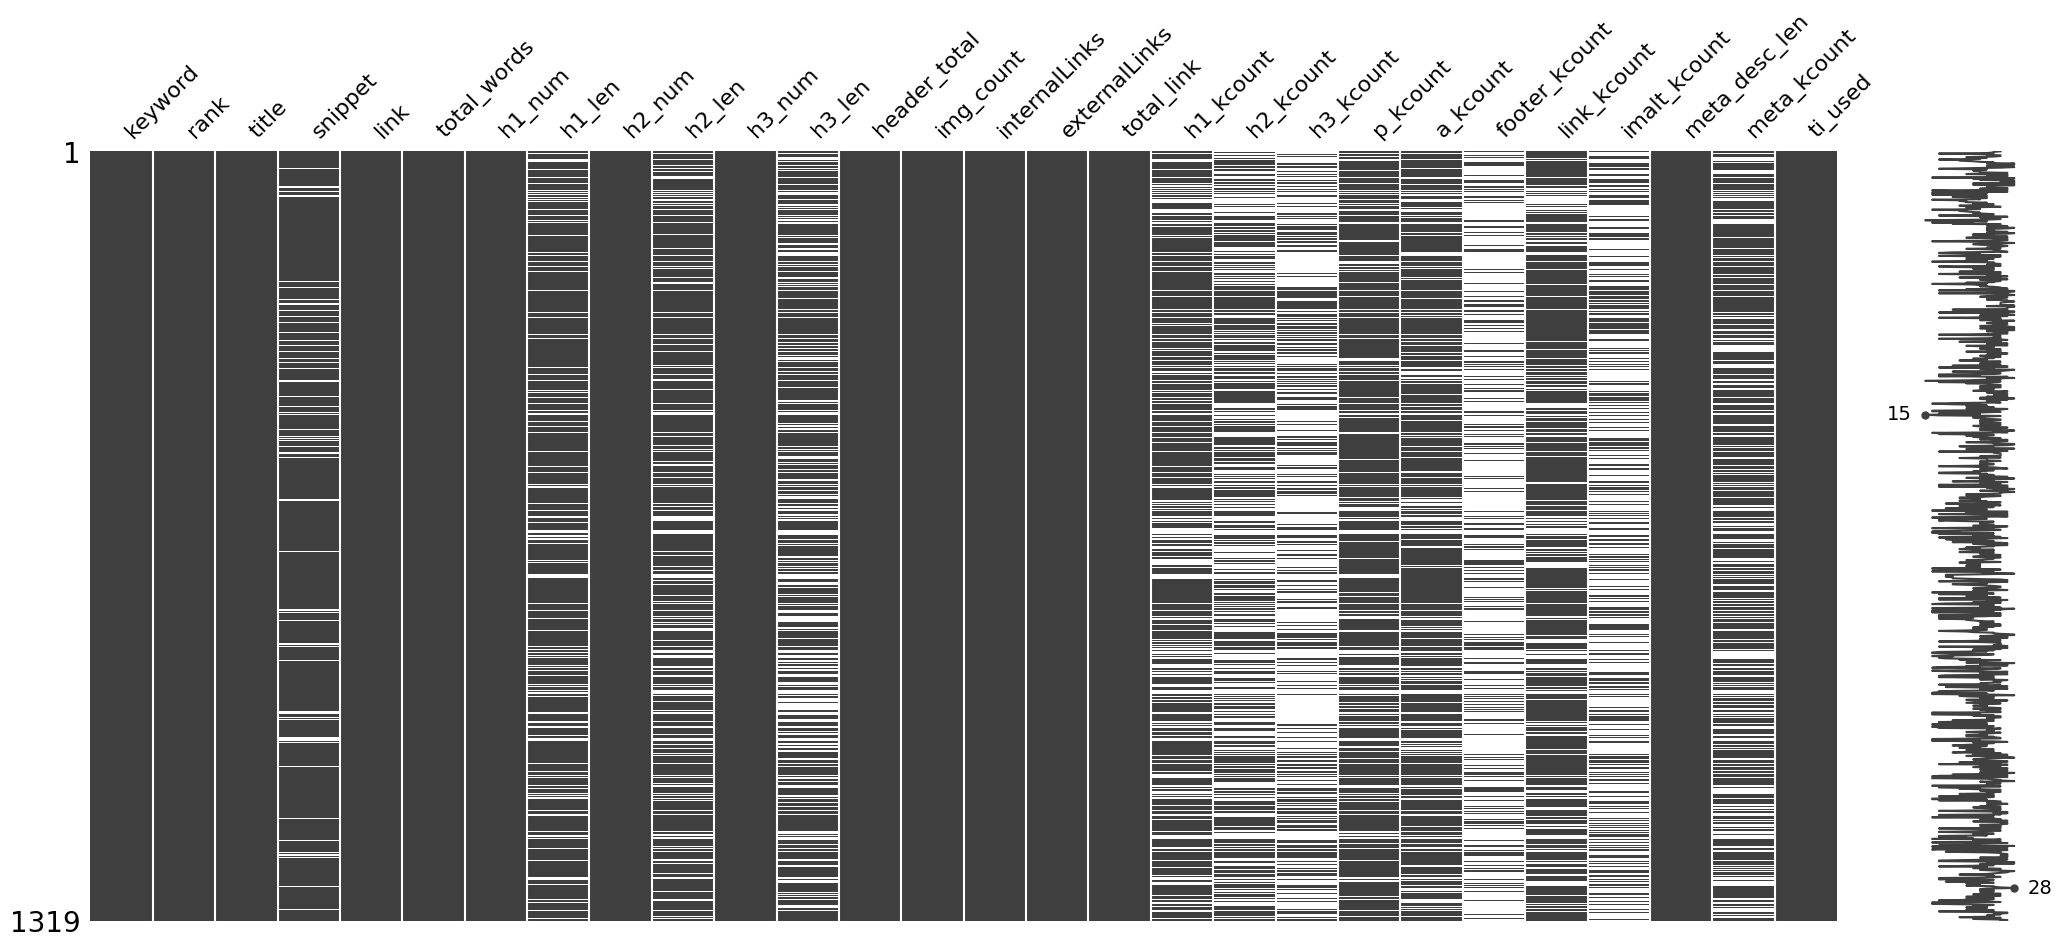

In [ ]:
# Examine missing values frequency
ax = missingno.matrix(df)

In [ ]:
#Take out columns that are stored in dict format
kcount = []
for c in df.columns:
  if "kcount" in c:
    kcount.append(c)

print(kcount)

['h1_kcount', 'h2_kcount', 'h3_kcount', 'p_kcount', 'a_kcount', 'footer_kcount', 'link_kcount', 'imalt_kcount', 'meta_kcount']


In [ ]:
# Change the data from those columns to the sum of occurence
for index, row in df.iterrows():
  for ck in kcount:
    strings = re.findall(r'\d+', str(row[ck]))
    a = [int(x) for x in strings]
    df.at[index, ck] = sum(a)

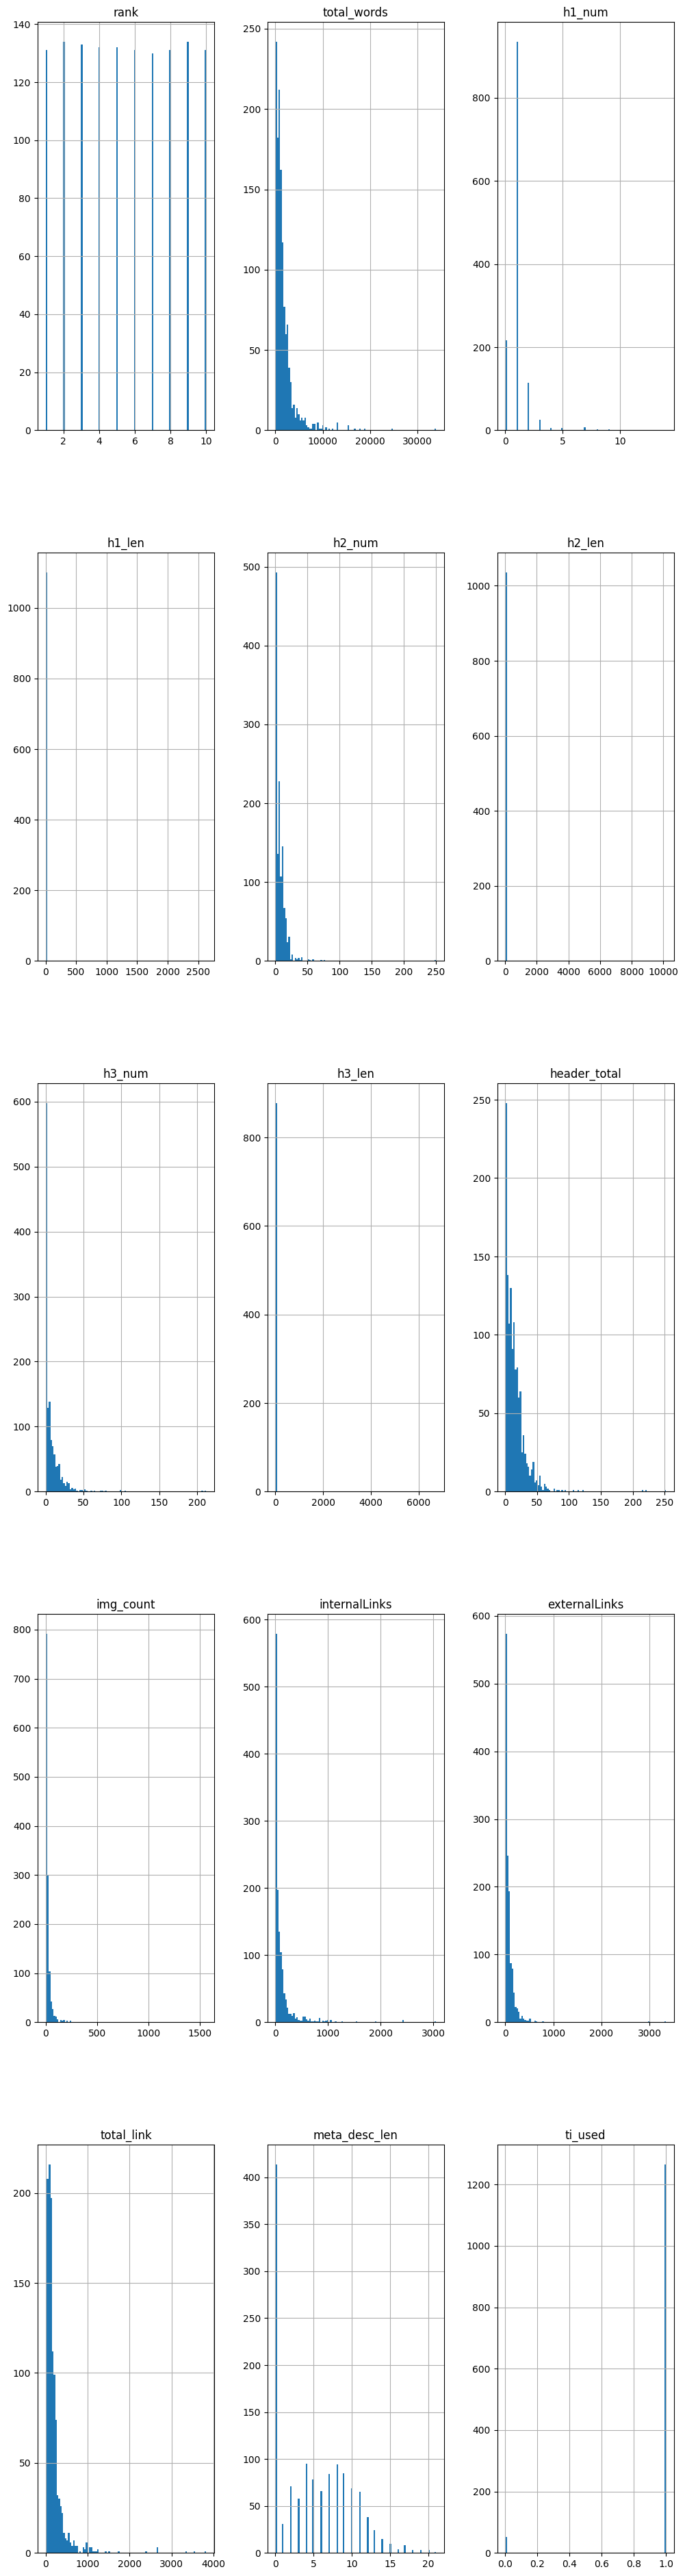

In [ ]:
# Histogram for all columns
%matplotlib inline
from itertools import combinations
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(df.select_dtypes(include=np.number).columns)//3, 3, figsize=(12, 48))

i = 0
for triaxis in axes:
    for axis in triaxis:
        df.hist(column = df.select_dtypes(include=np.number).columns[i], bins = 100, ax=axis)
        i = i+1

In [ ]:
#Fill all missing values from feature columns with 0
df[['h1_len','h2_len','h3_len']] = df[['h1_len','h2_len','h3_len']].fillna(0)
df.isnull().sum()

keyword            0
rank               0
title              0
snippet          110
link               0
total_words        0
h1_num             0
h1_len             0
h2_num             0
h2_len             0
h3_num             0
h3_len             0
header_total       0
img_count          0
internalLinks      0
externalLinks      0
total_link         0
h1_kcount          0
h2_kcount          0
h3_kcount          0
p_kcount           0
a_kcount           0
footer_kcount      0
link_kcount        0
imalt_kcount       0
meta_desc_len      0
meta_kcount        0
ti_used            0
dtype: int64

<ipython-input-10-51458f3d389b>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr = df.corr()


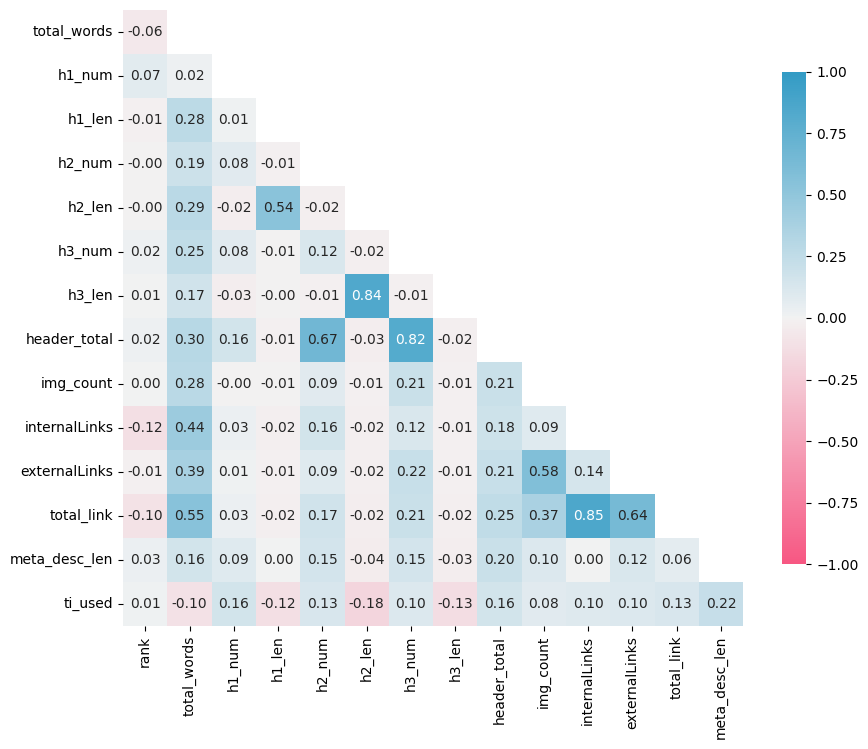

In [ ]:
#Correlation matrix
df_corr = df.corr()
fig, ax = plt.subplots(figsize=(10, 8))

mask = np.triu(np.ones_like(df_corr))

mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap=cmap,
           vmin=-1, vmax=1, cbar_kws={"shrink": .8})

plt.yticks(rotation=0)
plt.show()

In [ ]:
# Change the dataframe index to keyword
train_processed = df.copy()
train_processed.set_index("keyword",inplace=True)
train_processed.head(5)

,rank,title,snippet,link,total_words,h1_num,h1_len,h2_num,h2_len,h3_num,...,h2_kcount,h3_kcount,p_kcount,a_kcount,footer_kcount,link_kcount,imalt_kcount,meta_desc_len,meta_kcount,ti_used
keyword,,,,,,,,,,,,,,,,,,,,,
english for communication,1,Communication | Learning English,"Learn English with our free online listening, ...",https://www.cambridgeenglish.org/learning-engl...,641.0,2.0,1.5,3.0,4.33,4.0,...,0,0,3,4,10,2,3,1,1,1.0
english for communication,2,Improve Your English Communication Skills Spec...,Each course focuses on a particular area of co...,https://www.coursera.org/specializations/impro...,2144.0,1.0,6.0,12.0,2.83,18.0,...,0,5,23,8,0,1,0,5,2,1.0
english for communication,3,How to Improve Your Communication Skills in En...,"For both native speakers and ESOL speakers, st...",https://www.nu.edu/blog/how-to-improve-communi...,4873.0,1.0,8.0,19.0,4.47,6.0,...,6,0,95,18,0,2,0,10,2,1.0
english for communication,4,Skills | LearnEnglish,To build your vocabulary and develop your Engl...,https://learnenglish.britishcouncil.org/skills,590.0,1.0,1.0,16.0,2.88,0.0,...,2,0,11,12,8,0,1,1,0,1.0
english for communication,5,10 Ways To Improve Your English Communication ...,"Nov 7, 2022 — How To Improve Your English Comm...",https://in.indeed.com/career-advice/career-dev...,8.0,0.0,0.0,0.0,0.00,0.0,...,0,0,0,0,0,2,0,0,0,1.0


In [ ]:
train_processed.dtypes

rank               int64
title             object
snippet           object
link              object
total_words      float64
h1_num           float64
h1_len           float64
h2_num           float64
h2_len           float64
h3_num           float64
h3_len           float64
header_total       int64
img_count          int64
internalLinks      int64
externalLinks      int64
total_link         int64
h1_kcount         object
h2_kcount         object
h3_kcount         object
p_kcount          object
a_kcount          object
footer_kcount     object
link_kcount       object
imalt_kcount      object
meta_desc_len      int64
meta_kcount       object
ti_used          float64
dtype: object

In [ ]:

# Set features (ALL)
features = train_processed.iloc[:,4:].columns.tolist()
print(features)
print(len(features))

'''
# Set features (selected)
features = ['internalLinks', 'a_kcount', 'h2_len', 'externalLinks', 'total_words', 'img_count']
print(features)
print(len(features))
'''
# Set target
target = 'rank'

['total_words', 'h1_num', 'h1_len', 'h2_num', 'h2_len', 'h3_num', 'h3_len', 'header_total', 'img_count', 'internalLinks', 'externalLinks', 'total_link', 'h1_kcount', 'h2_kcount', 'h3_kcount', 'p_kcount', 'a_kcount', 'footer_kcount', 'link_kcount', 'imalt_kcount', 'meta_desc_len', 'meta_kcount', 'ti_used']
23


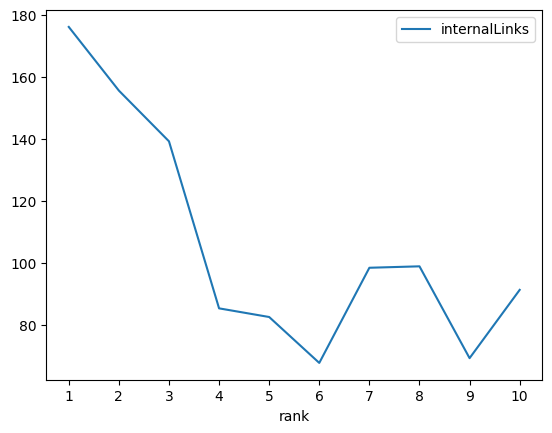

In [ ]:
#train_processed[features] = train_processed[features].apply(pd.to_numeric)
#mean_data = train_processed.groupby('rank').mean()

train_processed[['rank','internalLinks']].groupby('rank').mean().plot()
#mean_data.plot(subplots = True, layout=(12,2), figsize=(12, 50))

#plt.subplots_adjust(hspace=0.25)
plt.xticks(train_processed['rank'].unique())
plt.show()

In [ ]:
train_processed.groupby('rank').mean().astype(int)

<ipython-input-15-56992b1b5d4c>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train_processed.groupby('rank').mean().astype(int)


,total_words,h1_num,h1_len,h2_num,h2_len,h3_num,h3_len,header_total,img_count,internalLinks,externalLinks,total_link,meta_desc_len,ti_used
rank,,,,,,,,,,,,,,
1,1790,1,3,7,3,6,3,14,16,176,74,250,4,0
2,2103,1,4,8,3,7,3,16,25,155,87,242,4,0
3,1975,0,4,6,3,7,2,14,20,139,79,218,4,0
4,1561,0,25,6,52,6,3,13,21,85,59,144,5,0
5,1541,1,4,5,3,8,2,14,24,82,84,166,5,0
6,1393,1,3,5,80,5,53,12,13,67,56,124,4,0
7,1766,1,4,6,3,7,2,15,36,98,115,213,5,0
8,1645,1,4,8,3,9,4,18,23,98,65,164,5,0
9,1435,1,4,6,3,6,3,13,16,69,68,137,4,0


<Axes: >

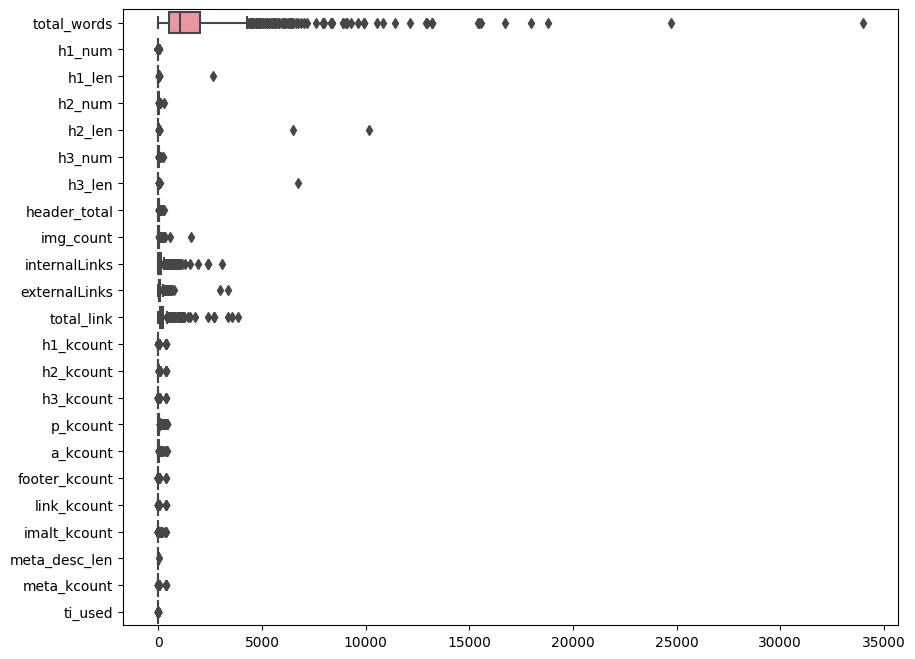

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df[features], orient="h")

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_processed[features])
scaled_features = scaler.transform(train_processed[features])
print(scaled_features)

[[-0.44461067  0.89664492 -0.06866627 ... -0.86335036 -0.08867239
   0.20460728]
 [ 0.19818092 -0.07276053 -0.00650089 ...  0.00859384 -0.04835564
   0.20460728]
 [ 1.36529884 -0.07276053  0.02112816 ...  1.09852409 -0.04835564
   0.20460728]
 ...
 [ 0.71352614 -0.07276053 -0.00650089 ...  0.88053804 -0.0080389
   0.20460728]
 [ 1.31226747 -0.07276053 -0.03412995 ...  0.66255199 -0.08867239
   0.20460728]
 [-0.01565527 -0.07276053 -0.07557353 ... -0.86335036 -0.08867239
   0.20460728]]


In [ ]:
pca = PCA(n_components=2)
pca.fit(scaled_features)
pca_features = pca.transform(scaled_features)
pca_features.shape

(1319, 2)

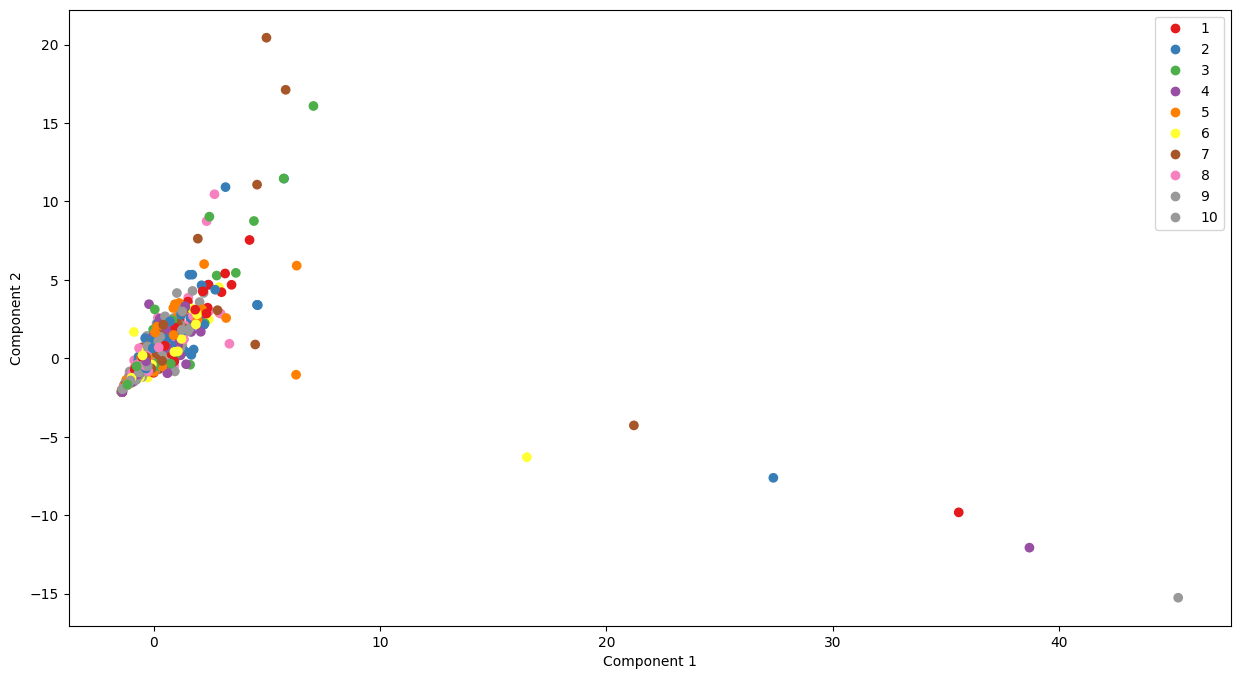

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
scatter = plt.scatter(x=pca_features[:,0], y=pca_features[:,1], c=df['rank'],cmap='Set1')
plt.legend(*scatter.legend_elements())
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

In [ ]:
#Split data
X,y = train_processed[features].apply(pd.to_numeric),train_processed[target].apply(pd.to_numeric)

xmain,xtest,ymain,ytest = train_test_split(X,y , random_state = 42,
                                   test_size=0.125,
                                   shuffle=True, stratify=y)
xtrain,xval,ytrain,yval = train_test_split(xmain,ymain, random_state = 100,
                                   test_size=0.125,
                                   shuffle=True, stratify=ymain)

In [ ]:
print(xtrain.shape,xval.shape,xtest.shape)

(1009, 23) (145, 23) (165, 23)


In [ ]:
# Get the the number of unique keywords in each dataset
get_group_size = lambda df: df.reset_index().groupby("keyword")['keyword'].count()


In [ ]:
df.reset_index().groupby("keyword")['keyword'].count()

keyword
Academic                            10
Case study research                 10
Education center                    10
Educational development             10
Educational technologies            10
                                    ..
what is the purpose of education    10
windows 10 education                 7
women education                     10
world education services            10
writing a good CV                   10
Name: keyword, Length: 135, dtype: int64

In [ ]:
train_groups = get_group_size(xtrain)
val_groups = get_group_size(xval)

In [ ]:
train_groups

keyword
Academic                            6
Case study research                 7
Education center                    6
Educational development             8
Educational technologies            9
                                   ..
what is the purpose of education    9
windows 10 education                6
women education                     8
world education services            6
writing a good CV                   9
Name: keyword, Length: 135, dtype: int64

In [ ]:
val_groups

keyword
Academic                            3
Case study research                 3
Education center                    2
Educational technologies            1
Experiential learning               1
                                   ..
what is physical education          2
what is post secondary education    2
what is the purpose of education    1
world education services            3
writing a good CV                   1
Name: keyword, Length: 94, dtype: int64

## **LIGHT GBM**

In [ ]:
#Cross-validation
'''
features_light = df.iloc[:,5:].columns.tolist()
features_light.insert(0, 'keyword')

target_light = 'rank'
get_group_size = lambda df: df.reset_index().groupby("keyword")['keyword'].count()

X,y = df[features_light],df[target_light]

avg_ndcg = []

from sklearn.model_selection import StratifiedGroupKFold
sgk = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=104)

fold = 0
aucs = []
for train_idx, val_idx  in sgk.split(X, y, df['keyword']):
    X_tr = X.loc[train_idx]
    train_groups = get_group_size(X_tr)
    X_tr = X_tr.drop('keyword', axis=1)
    X_tr = X_tr.apply(pd.to_numeric)
    y_tr = y.loc[train_idx]
    y_tr = y_tr.apply(pd.to_numeric)

    X_val = X.loc[val_idx]
    test_groups = get_group_size(X_val)
    X_val = X_val.drop('keyword', axis=1)
    X_val = X_val.apply(pd.to_numeric)
    y_val = y.loc[val_idx]
    y_val = y_val.apply(pd.to_numeric)

    print(X_tr.shape, y_tr.shape, X_val.shape, y_val.shape)

    # Fit Model on Train

    model = LGBMRanker(objective="lambdarank",n_estimators=100)
    model.fit(X_tr,y_tr,group=train_groups,eval_set=[(X_val,y_val)],eval_group=[test_groups],eval_metric=['ndcg@10'], eval_at=10,verbose=10)
    pred = model.predict(X_val, pred_contrib = True)
    #print('PRED: ', pred)
    avg_ndcg.append(model.best_score_)

#avg_ndcg = [int(x) for x in avg_ndcg]
#print("Average ndcg:", sum(avg_ndcg) / len(avg_ndcg))
print(avg_ndcg)

'''


'\nfeatures_light = df.iloc[:,5:].columns.tolist()\nfeatures_light.insert(0, \'keyword\')\n\ntarget_light = \'rank\'\nget_group_size = lambda df: df.reset_index().groupby("keyword")[\'keyword\'].count()\n\nX,y = df[features_light],df[target_light]\n\navg_ndcg = []\n\nfrom sklearn.model_selection import StratifiedGroupKFold\nsgk = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=104)\n\nfold = 0\naucs = []\nfor train_idx, val_idx  in sgk.split(X, y, df[\'keyword\']):\n    X_tr = X.loc[train_idx]\n    train_groups = get_group_size(X_tr)\n    X_tr = X_tr.drop(\'keyword\', axis=1)\n    X_tr = X_tr.apply(pd.to_numeric)\n    y_tr = y.loc[train_idx]\n    y_tr = y_tr.apply(pd.to_numeric)\n    \n    X_val = X.loc[val_idx]\n    test_groups = get_group_size(X_val)\n    X_val = X_val.drop(\'keyword\', axis=1)\n    X_val = X_val.apply(pd.to_numeric)\n    y_val = y.loc[val_idx]\n    y_val = y_val.apply(pd.to_numeric)\n\n    print(X_tr.shape, y_tr.shape, X_val.shape, y_val.shape)\n\n    # 

In [ ]:
#Fit model
model_lg = LGBMRanker(objective="lambdarank")
model_lg.fit(xtrain,ytrain,group=train_groups,eval_set=[(xval,yval)],eval_group=[val_groups],eval_metric=['ndcg@10'], eval_at=10,verbose=10)

[10]	valid_0's ndcg@10: 0.95863


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's ndcg@10: 0.951434
[30]	valid_0's ndcg@10: 0.963702
[40]	valid_0's ndcg@10: 0.960072
[50]	valid_0's ndcg@10: 0.958889
[60]	valid_0's ndcg@10: 0.948046
[70]	valid_0's ndcg@10: 0.95177
[80]	valid_0's ndcg@10: 0.950514
[90]	valid_0's ndcg@10: 0.949477
[100]	valid_0's ndcg@10: 0.951053


LGBMRanker(objective='lambdarank')

In [ ]:
#Fit model (tunned)
model_lg = LGBMRanker(objective="lambdarank", learning_rate= 0.12,n_estimators=400, num_leaves=27, max_depth= 199)
model_lg.fit(xtrain,ytrain,group=train_groups,eval_set=[(xval,yval)],eval_group=[val_groups],eval_metric=['ndcg@10'], eval_at=10,verbose=10)

/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's ndcg@10: 0.95319
[20]	valid_0's ndcg@10: 0.953335
[30]	valid_0's ndcg@10: 0.963924
[40]	valid_0's ndcg@10: 0.953837
[50]	valid_0's ndcg@10: 0.961746
[60]	valid_0's ndcg@10: 0.961631
[70]	valid_0's ndcg@10: 0.968889
[80]	valid_0's ndcg@10: 0.963867
[90]	valid_0's ndcg@10: 0.966142
[100]	valid_0's ndcg@10: 0.965125
[110]	valid_0's ndcg@10: 0.963188
[120]	valid_0's ndcg@10: 0.963188
[130]	valid_0's ndcg@10: 0.963188
[140]	valid_0's ndcg@10: 0.966818
[150]	valid_0's ndcg@10: 0.966818
[160]	valid_0's ndcg@10: 0.970658
[170]	valid_0's ndcg@10: 0.970658
[180]	valid_0's ndcg@10: 0.967027
[190]	valid_0's ndcg@10: 0.974394
[200]	valid_0's ndcg@10: 0.974394
[210]	valid_0's ndcg@10: 0.97063
[220]	valid_0's ndcg@10: 0.9622
[230]	valid_0's ndcg@10: 0.969655
[240]	valid_0's ndcg@10: 0.965742
[250]	valid_0's ndcg@10: 0.965742
[260]	valid_0's ndcg@10: 0.965742
[270]	valid_0's ndcg@10: 0.965742
[280]	valid_0's ndcg@10: 0.965699
[290]	valid_0's ndcg@10: 0.958318
[300]	valid_0's ndcg@10: 0.

LGBMRanker(learning_rate=0.12, max_depth=199, n_estimators=400, num_leaves=27,
           objective='lambdarank')

In [ ]:
list(model_lg.best_score_['valid_0'].values())

[0.9621573623734502]

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.5 MB/s eta 0:00:00


In [ ]:
'''
import optuna
import lightgbm as lgb



def objective(trial):

    ranking_param_grid = {
        'learning_rate': trial.suggest_float('learning_rate', 0.06, 0.14, step=0.02),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=100),
        'num_leaves': trial.suggest_int('num_leaves', 25, 35, 1),
        'max_depth': trial.suggest_int('max_depth', -1, 500, 50)
    }

    gbm = lgb.LGBMRanker(n_jobs=24, **ranking_param_grid)
    gbm.fit(xtrain,ytrain,group=train_groups,eval_set=[(xval,yval)],eval_group=[val_groups],
                    eval_metric='ndcg', eval_at=[10, 50, 100],
                    early_stopping_rounds=100, verbose=False)

    return list(gbm.best_score_['valid_0'].values())[2]

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
'''

"\nimport optuna\nimport lightgbm as lgb\n\n\n    \ndef objective(trial):\n\n    ranking_param_grid = {\n        'learning_rate': trial.suggest_float('learning_rate', 0.06, 0.14, step=0.02),\n        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=100),\n        'num_leaves': trial.suggest_int('num_leaves', 25, 35, 1),\n        'max_depth': trial.suggest_int('max_depth', -1, 500, 50)\n    }\n    \n    gbm = lgb.LGBMRanker(n_jobs=24, **ranking_param_grid)\n    gbm.fit(xtrain,ytrain,group=train_groups,eval_set=[(xval,yval)],eval_group=[val_groups],\n                    eval_metric='ndcg', eval_at=[10, 50, 100],\n                    early_stopping_rounds=100, verbose=False)\n    \n    return list(gbm.best_score_['valid_0'].values())[2]\n\nstudy = optuna.create_study(direction='maximize')\nstudy.optimize(objective, n_trials=200)\n \nprint('Number of finished trials:', len(study.trials))\nprint('Best trial:', study.best_trial.params)\n"

In [ ]:
#LIGHT GBM RESULT
from sklearn.metrics import ndcg_score
y_test = np.asarray([ytest])
y_pred = np.asarray([model_lg.predict(xtest)])
ndcg_score(y_test, y_pred)

0.8840222934913867

In [ ]:
#import lightgbm as lightgbm
#lightgbm.plot_importance(model_lg, figsize = (12,8))

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 28.8 MB/s eta 0:00:00


In [ ]:
import shap
def generate_shap_plots(ranker, X_train, feature_names, N=3):
    """
    Generates SHAP plots for a pre-trained LightGBM model.

    Parameters:
        ranker (lightgbm.Booster): A trained LightGBM model
        X_train (np.ndarray): The training data used to fit the model
        feature_names (List): list of feature names
        N (int): The number of plots to generate

    Returns:
        None
    """
    explainer = shap.Explainer(ranker, X_train, feature_names=feature_names)
    shap_values = explainer(X_train.iloc[:N])

    # Create a figure with 2 subplots
    #fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    plt.figure(figsize=(20,20))

    # Plot the summary plot on the first subplot

    #plt.subplot(3, 1, 1)
    shap.summary_plot(shap_values, feature_names=feature_names, plot_type='bar')

    # Plot the feature importance plot on the second subplot
    #plt.subplot(3, 1, 2)
    shap.summary_plot(shap_values, feature_names=feature_names, plot_type='dot')

    #plt.subplot(3, 1, 3)
    #shap.summary_plot(shap_values, feature_names=feature_names, plot_type='violin')


    plt.show()

 99%|===================| 997/1009 [00:49<00:00]       

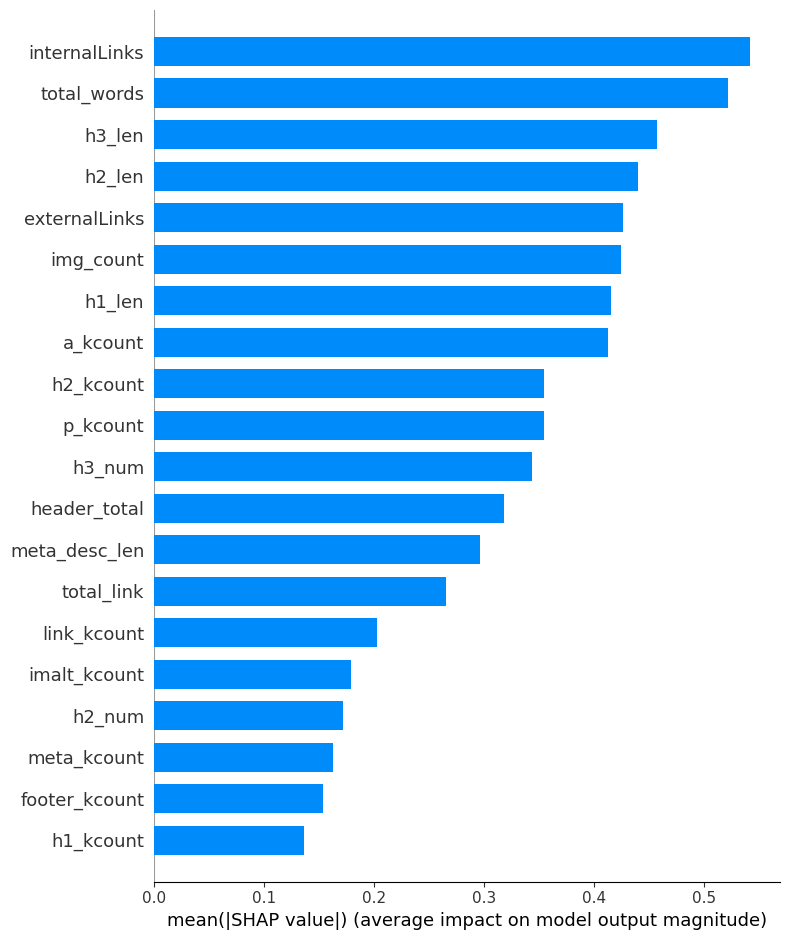

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


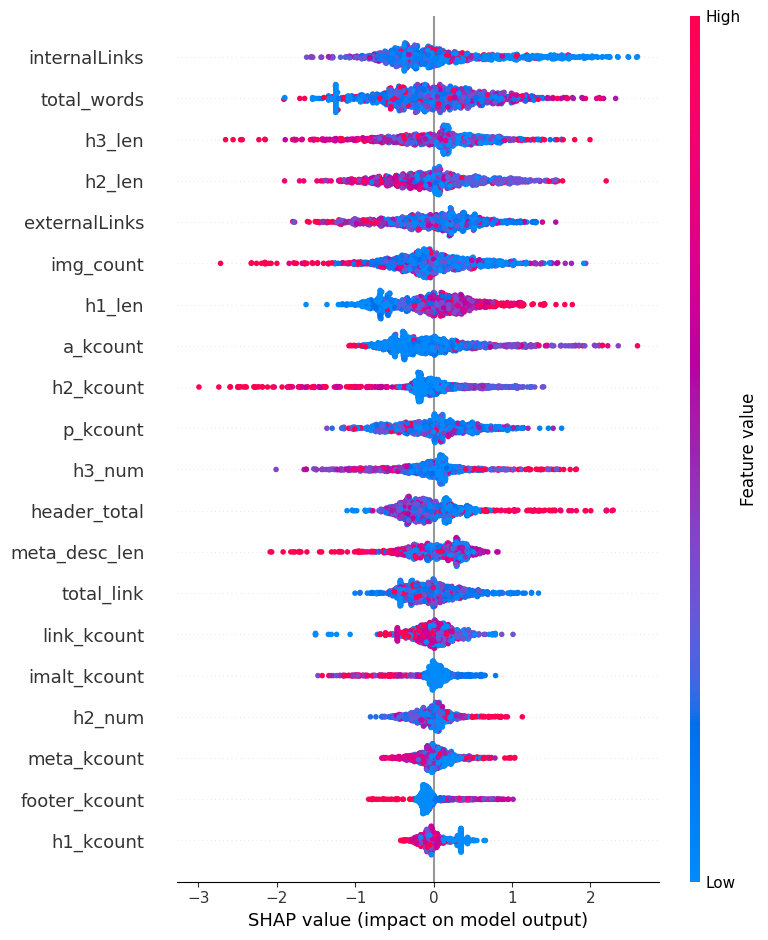

In [ ]:
generate_shap_plots(model_lg,xtrain,features,N=2000)

## **XGBOOST**

In [ ]:
from xgboost import XGBRanker
model_xg = XGBRanker(objective='rank:ndcg')
model_xg.fit(xtrain,ytrain,group=train_groups,eval_set=[(xval,yval)],eval_group=[val_groups],eval_metric=['ndcg@10'], verbose=10)


[0]	validation_0-ndcg@10:0.94055
[10]	validation_0-ndcg@10:0.95209
[20]	validation_0-ndcg@10:0.95669
[30]	validation_0-ndcg@10:0.95511
[40]	validation_0-ndcg@10:0.95389


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[50]	validation_0-ndcg@10:0.95785
[60]	validation_0-ndcg@10:0.95401
[70]	validation_0-ndcg@10:0.96263
[80]	validation_0-ndcg@10:0.96263
[90]	validation_0-ndcg@10:0.96294
[99]	validation_0-ndcg@10:0.96310


XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
          grow_policy=None, importance_type=None, interaction_constraints=None,
          learning_rate=None, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, n_estimators=100, n_jobs=None,
          num_parallel_tree=None, objective='rank:ndcg', predictor=None, ...)

In [ ]:
#XGBOOST RESULT
from sklearn.metrics import ndcg_score
y_test = np.asarray([ytest])
y_pred = np.asarray([model_xg.predict(xtest)])
ndcg_score(y_test, y_pred)

0.8976807663200945

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

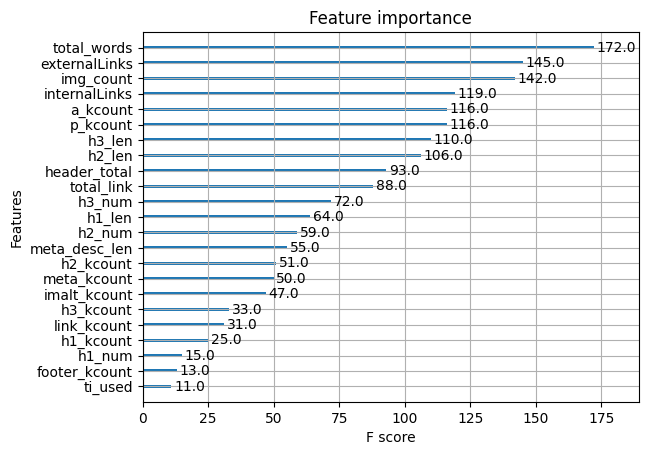

In [ ]:
import xgboost as xgboost
xgboost.plot_importance(model_xg)

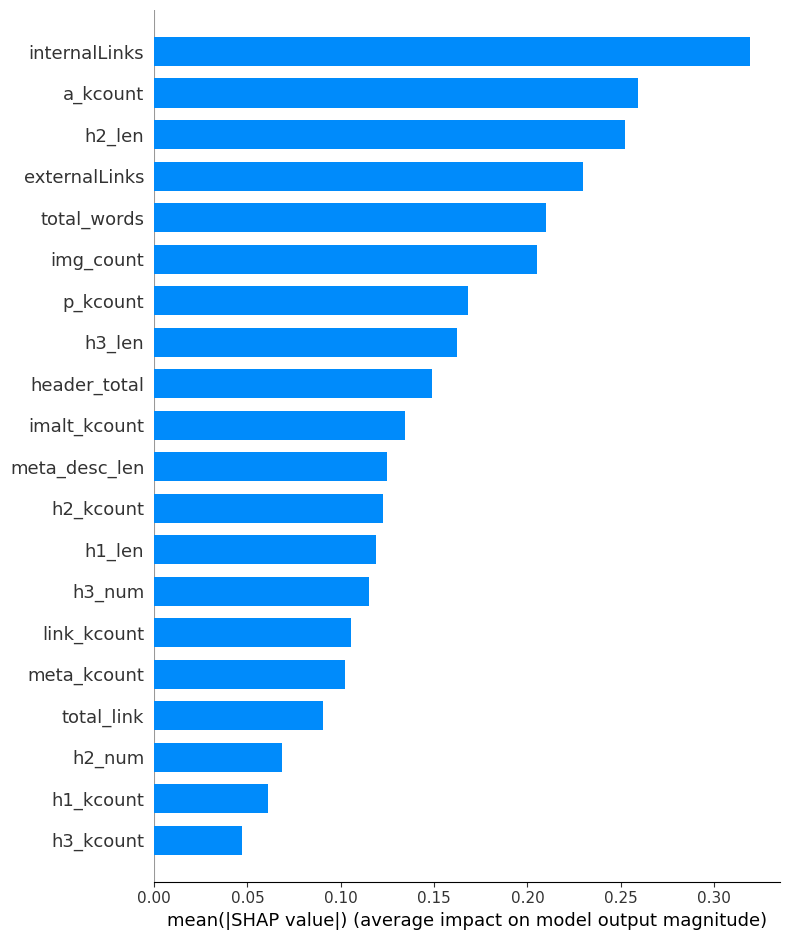

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


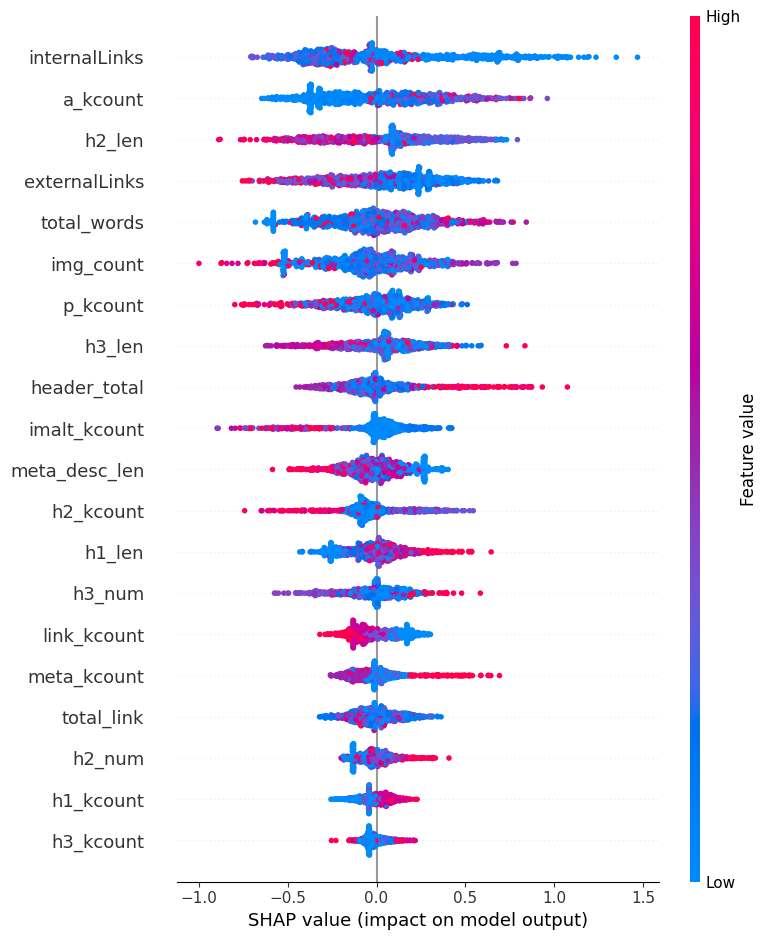

In [ ]:
generate_shap_plots(model_xg,xtrain,features,N=2000)

In [ ]:
def get_group_labels(df):
    labels, uniques = pd.factorize(df.index.values, sort=True)
    return labels


print(get_group_labels(X))

[66 66 66 ... 26 26 26]
